# Calculate seasonal ice velocity at all Arctic points

* **Description**: Reads in and creates spatial plots of wind trends
* **Input data**: CESM2-LE and Rufmod output in timeseries format
* **Output data**: PNG figures of trends
* **Creator**: Alice DuVivier
* **Date**: September 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks.

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
from datetime import timedelta
import glob
import geocat.datafiles as gdf
import geocat.viz.util as gvutil
from geocat.viz import cmaps as gvcmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from scipy import stats
from scipy.stats import linregress,pearsonr, t

import dask
import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

In [2]:
# spin up dask cluster

import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42097 instead
  f"Port {expected} is already in use.\n"


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/42097/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/42097/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.18:42470,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/42097/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Manually set variables

In [4]:
# list the variables to load
var_in_1 = 'uvel'
var_in_2 = 'vvel'
# also load aice to mask
var_in_aice = 'aice'

## Load rufmod experiments

In [5]:
# Load "rufmod" data
#choose cases and data paths
case1 = 'b.e21.BSSP370.f09_g17.rufmod.001'
case2 = 'b.e21.BSSP370.f09_g17.rufmod.002'
case3 = 'b.e21.BSSP370.f09_g17.rufmod.003'
case4 = 'b.e21.BSSP370.f09_g17.rufmod.004'
case5 = 'b.e21.BSSP370.f09_g17.rufmod.005'

# set base directory where all data live
data_dir = '/glade/campaign/cesm/development/pcwg/projects/arctic_cyclones/rufmod_expts/'
# set individual data directories
data_dir1 = data_dir+case1+'/ice/proc/tseries/month_1/'
data_dir2 = data_dir+case2+'/ice/proc/tseries/month_1/'
data_dir3 = data_dir+case3+'/ice/proc/tseries/month_1/'
data_dir4 = data_dir+case4+'/ice/proc/tseries/month_1/'
data_dir5 = data_dir+case5+'/ice/proc/tseries/month_1/'

In [6]:
%%time
#reading in files - VAR1
print("loading "+var_in_1)   
ds1_1 = []
ds2_1 = []
ds3_1 = []
ds4_1 = []
ds5_1 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cice.h.'+var_in_1+'.*.nc'))
ds1_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cice.h.'+var_in_1+'.*.nc'))
ds2_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cice.h.'+var_in_1+'.*.nc'))
ds3_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cice.h.'+var_in_1+'.*.nc'))
ds4_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cice.h.'+var_in_1+'.*.nc'))
ds5_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

# concatenate them into a single array
future_1 = xr.concat([ds1_1,ds2_1,ds3_1,ds4_1,ds5_1],dim='member_id')

loading uvel
CPU times: user 1.5 s, sys: 340 ms, total: 1.84 s
Wall time: 40.4 s


In [7]:
%%time
#reading in files - VAR2
print("loading "+var_in_2)   
ds1_1 = []
ds2_1 = []
ds3_1 = []
ds4_1 = []
ds5_1 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cice.h.'+var_in_2+'.*.nc'))
ds1_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cice.h.'+var_in_2+'.*.nc'))
ds2_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cice.h.'+var_in_2+'.*.nc'))
ds3_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cice.h.'+var_in_2+'.*.nc'))
ds4_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cice.h.'+var_in_2+'.*.nc'))
ds5_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

# concatenate them into a single array
future_2 = xr.concat([ds1_1,ds2_1,ds3_1,ds4_1,ds5_1],dim='member_id')

loading vvel
CPU times: user 945 ms, sys: 118 ms, total: 1.06 s
Wall time: 18.9 s


In [8]:
# set member_id values
future_1.member_id.values
future_2.member_id.values

# assign member_id as coordinate array
future_1.assign_coords({"member_id": future_1.member_id.values})
future_2.assign_coords({"member_id": future_2.member_id.values})

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 5, time: 1032, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id    (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 600, 2), meta=np.ndarray>
    vvel         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370.f09_g17.rufmod.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-07-14 at 12:33
    io_flavor:         io_pio

In [9]:
future_1

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 5, time: 1032, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nj, ni, member_id, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 600, 2), meta=np.ndarray>
    uvel         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370.f09_g17.rufmod.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-07-14 at 12:33
    io_flavor:         io_pio

In [10]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
future_1['time'] = future_1.time_bounds.load().mean(dim='d2').sel(member_id=0)
future_2['time'] = future_2.time_bounds.load().mean(dim='d2').sel(member_id=0)

In [11]:
future_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [12]:
uvel_rufmod = future_1[var_in_1]
vvel_rufmod = future_2[var_in_2]

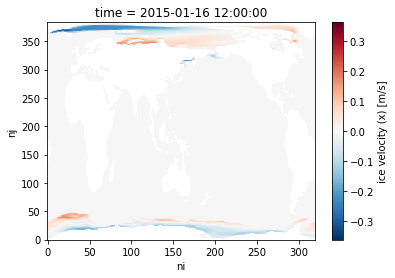

In [13]:
uvel_rufmod.sel(member_id=0).isel(time=0).plot()

In [14]:
#mask just NH points
uvel_masked_rufmod = uvel_rufmod.isel(nj=slice(300,384))
vvel_masked_rufmod = vvel_rufmod.isel(nj=slice(300,384))

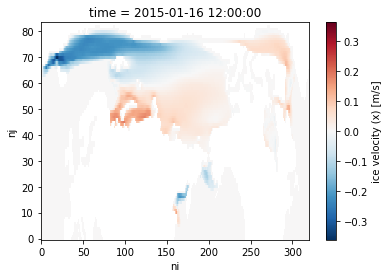

In [15]:
uvel_masked_rufmod.sel(member_id=0).isel(time=0).plot()

In [16]:
uvel_masked_rufmod.load()
vvel_masked_rufmod.load()

<xarray.DataArray 'vvel' (member_id: 5, time: 1032, nj: 84, ni: 320)>
array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 325.0 ... nan nan nan nan
    TLAT     (nj, ni) float32 39.14 39.14 39.14 39.15 39.15 ... nan nan nan nan
    ULON     (nj, ni) float32 321.1 322.2 323.3 324.4 325.5 ... nan nan nan nan
    ULAT     (nj, ni) float32 39.35 39.35 39.35 39.36 39.37 ... nan nan nan nan
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: member_id, nj, ni
Attributes:
    units:          m/s
    long_name:      ice velocity (y)
    cell_measures:  area: uarea
    cell_methods:   time: mean
    time_rep:       averaged

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [17]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [18]:
forcing = 'cmip6'  # do not want smbb data
expt = 'ssp370'
comp = 'ice'
freq = 'month_1'

subset_1 = cat.search(variable=var_in_1, forcing_variant=forcing, experiment=expt, component=comp, frequency=freq )
subset_2 = cat.search(variable=var_in_2, forcing_variant=forcing, experiment=expt, component=comp, frequency=freq )

In [19]:
subset_1

,unique
component,1
stream,1
case,50
member_id,50
variable,1
start_time,9
end_time,9
time_range,9
long_name,1
units,1


In [20]:
subset_1.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,uvel,2015-01,2024-12,201501-202412,ice velocity (x),m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
1,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,uvel,2025-01,2034-12,202501-203412,ice velocity (x),m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
2,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,uvel,2035-01,2044-12,203501-204412,ice velocity (x),m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
3,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,uvel,2045-01,2054-12,204501-205412,ice velocity (x),m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
4,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,uvel,2055-01,2064-12,205501-206412,ice velocity (x),m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1


In [21]:
# check that we only have cmip6, not smbb, data
member_id = list(subset_1.df.experiment.unique())
print(member_id)

['ssp370']


In [22]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_1 = subset_1.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})
    dsets_2 = subset_2.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 12.7 s, sys: 236 ms, total: 12.9 s
Wall time: 15.4 s


In [23]:
# load in the future datasets
future_1 = []
for key in sorted(dsets_1.keys()):
    future_1.append(dsets_1[key])
    print(key)
    

ice.ssp370.cice.h.cmip6.uvel


In [24]:
# load in the future datasets
future_2 = []
for key in sorted(dsets_2.keys()):
    future_2.append(dsets_2[key])
    print(key)

ice.ssp370.cice.h.cmip6.vvel


In [25]:
future_ds_1 = xr.concat(future_1, dim='member_id')
future_ds_2 = xr.concat(future_2, dim='member_id')

In [26]:
future_ds_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  model time
    bounds:     time_bounds

In [27]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
future_ds_1['time'] = future_ds_1.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')
future_ds_2['time'] = future_ds_2.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')

In [28]:
uvel_le = future_ds_1[var_in_1]
vvel_le = future_ds_2[var_in_2]

In [29]:
uvel_le.persist()
vvel_le.persist()

<xarray.DataArray 'vvel' (member_id: 50, time: 1032, nj: 384, ni: 320)>
dask.array<concatenate, shape=(50, 1032, 384, 320), dtype=float32, chunksize=(1, 120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          m/s
    long_name:      ice velocity (y)
    cell_measures:  area: uarea
    cell_methods:   time: mean
    time_rep:       averaged

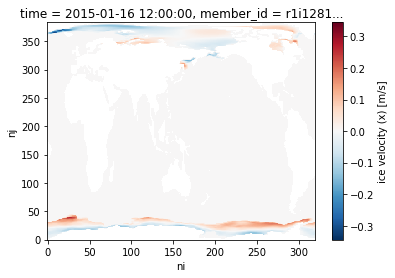

In [31]:
uvel_le.sel(member_id='r1i1281p1f1').isel(time=0).plot()

In [32]:
#mask just NH points
uvel_masked_le = uvel_le.isel(nj=slice(300,384))
vvel_masked_le = vvel_le.isel(nj=slice(300,384))

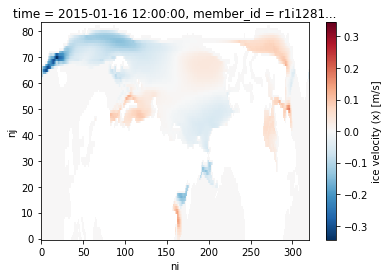

In [33]:
uvel_masked_le.sel(member_id='r1i1281p1f1').isel(time=0).plot()

In [34]:
uvel_masked_le.load()
vvel_masked_le.load()

<xarray.DataArray 'vvel' (member_id: 50, time: 1032, nj: 84, ni: 320)>
array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT       (nj, ni) float32 39.14 39.14 39.14 39.15 ... nan nan nan nan
    ULON       (nj, ni) float32 321.1 322.2 323.3 324.4 ... nan nan nan nan
    ULAT       (nj, ni) float32 39.35 39.35 39.35 39.36 ... nan nan nan nan
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          m/s
    long_name:      ice velocity (y)
    cell_measures:  area: uarea
    cell_methods:   time: mean
    time_rep:       averaged

## Load ice area data for masking

#### Rufmod experiments

In [35]:
%%time
#reading in files
print("loading "+var_in_aice)   
ds1_aice = []
ds2_aice = []
ds3_aice = []
ds4_aice = []
ds5_aice = []
my_files=sorted(glob.glob(data_dir1+case1+'.cice.h.'+var_in_aice+'.*.nc'))
ds1_aice=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cice.h.'+var_in_aice+'.*.nc'))
ds2_aice=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cice.h.'+var_in_aice+'.*.nc'))
ds3_aice=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cice.h.'+var_in_aice+'.*.nc'))
ds4_aice=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cice.h.'+var_in_aice+'.*.nc'))
ds5_aice=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

loading aice
CPU times: user 291 ms, sys: 78.6 ms, total: 370 ms
Wall time: 2.31 s


In [36]:
# concatenate them into a single array
futures_aice = xr.concat([ds1_aice,ds2_aice,ds3_aice,ds4_aice,ds5_aice],dim='member_id')

# set member_id values
futures_aice.member_id.values

# assign member_id as coordinate array
futures_aice.assign_coords({"member_id": futures_aice.member_id.values})

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 5, time: 1032, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id    (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 600, 2), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370.f09_g17.rufmod.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-07-14 at 12:33
    io_flavor:         io_pio

In [37]:
# Shift months by one to be center of time period.
futures_aice['time'] = futures_aice.time_bounds.load().mean(dim='d2').sel(member_id=0)

# grab just the variable we need
aice_rufmod = futures_aice[var_in_aice]

#mask just NH points
aice_masked_rufmod = aice_rufmod.isel(nj=slice(300,384))

In [38]:
aice_masked_rufmod.load()

<xarray.DataArray 'aice' (member_id: 5, time: 1032, nj: 84, ni: 320)>
array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 325.0 ... nan nan nan nan
    TLAT     (nj, ni) float32 39.14 39.14 39.14 39.15 39.15 ... nan nan nan nan
    ULON     (nj, ni) float32 321.1 322.2 323.3 324.4 325.5 ... nan nan nan nan
    ULAT     (nj, ni) float32 39.35 39.35 39.35 39.36 39.37 ... nan nan nan nan
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: member_id, nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

#### CESM-LE experiments

In [39]:
subset_aice = cat.search(variable=var_in_aice, forcing_variant=forcing, experiment=expt, component=comp, frequency=freq )

In [40]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_aice = subset_aice.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 6.63 s, sys: 214 ms, total: 6.85 s
Wall time: 8.79 s


In [41]:
# load in the future datasets
futures_aice = []
for key in sorted(dsets_aice.keys()):
    futures_aice.append(dsets_aice[key])
    print(key)

ice.ssp370.cice.h.cmip6.aice


In [42]:
# combine into one array
future_ds_aice = xr.concat(futures_aice, dim='member_id')

# Shift months by one to be center of time period.
future_ds_aice['time'] = future_ds_aice.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')

# grab just the variable we need
aice_le = future_ds_aice[var_in_aice]

#mask just NH points
aice_masked_le = aice_le.isel(nj=slice(300,384))

In [43]:
aice_masked_le.load()

<xarray.DataArray 'aice' (member_id: 50, time: 1032, nj: 84, ni: 320)>
array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT       (nj, ni) float32 39.14 39.14 39.14 39.15 ... nan nan nan nan
    ULON       (nj, ni) float32 321.1 322.2 323.3 324.4 ... nan nan nan nan
    ULAT       (nj, ni) float32 39.35 39.35 39.35 39.36 ... nan nan nan nan
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## Mask the variables of interest by the ice concentration

In [44]:
# convert both aice arrays to % not, fraction
aice_masked_le = aice_masked_le*100.0
aice_masked_rufmod = aice_masked_rufmod*100.0

# set ice concentration threshold to mask by
aicemin = 15.0

In [45]:
# mask both datasets by their respective aice values
uvel_masked_le = uvel_masked_le.where(aice_masked_le > aicemin)
vvel_masked_le = vvel_masked_le.where(aice_masked_le > aicemin)

uvel_masked_rufmod = uvel_masked_rufmod.where(aice_masked_rufmod > aicemin)
vvel_masked_rufmod = vvel_masked_rufmod.where(aice_masked_rufmod > aicemin)

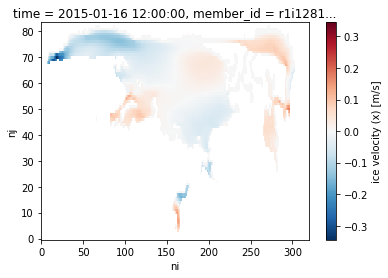

In [46]:
uvel_masked_le.sel(member_id='r1i1281p1f1').isel(time=0).plot()

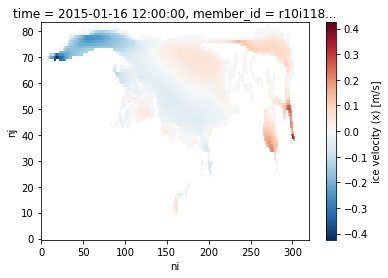

In [47]:
uvel_masked_le[0,0,:,:].plot()

## Calculate seasonal means

In [48]:
season_names = ['JFM', 'MAR', 'ANN']

In [49]:
# find total years
xarr_le = uvel_masked_le.coords['time.year'][(uvel_masked_le.coords['time.month']==1)]
xarr_rufmod = uvel_masked_rufmod.coords['time.year'][(uvel_masked_rufmod.coords['time.month']==1)]

In [50]:
# Loop through seasons - rufmod
print('Calculating Seasonal Means - SMOOTH')

# make numpy array to fill and specify dimensions we want
seas_array_1_rufmod = np.zeros([len(season_names),len(xarr_rufmod),len(uvel_masked_rufmod.member_id),len(uvel_masked_rufmod.nj),len(uvel_masked_rufmod.ni)])
seas_array_2_rufmod = np.zeros([len(season_names),len(xarr_rufmod),len(uvel_masked_rufmod.member_id),len(uvel_masked_rufmod.nj),len(uvel_masked_rufmod.ni)])

for ss in season_names:
    print(ss)
    if ss == 'JFM':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = uvel_masked_rufmod.isel(time=uvel_masked_rufmod.time.dt.month.isin([1,2,3]))
        temp2 = vvel_masked_rufmod.isel(time=vvel_masked_rufmod.time.dt.month.isin([1,2,3]))
    if ss == 'MAR':
        temp1 = uvel_masked_rufmod.isel(time=uvel_masked_rufmod.time.dt.month.isin([3]))
        temp2 = vvel_masked_rufmod.isel(time=vvel_masked_rufmod.time.dt.month.isin([3]))
    if ss == 'ANN':
        temp1 = uvel_masked_rufmod
        temp2 = vvel_masked_rufmod

    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_rufmod:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp1a = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        temp1b = temp1a.mean(dim='time')
        seas_array_1_rufmod[s_count,y_count,:,:,:] = temp1b    
        
        temp2a = temp2.isel(time=temp2.time.dt.year.isin([yy]))
        temp2b = temp2a.mean(dim='time')
        seas_array_2_rufmod[s_count,y_count,:,:,:] = temp2b    

Calculating Seasonal Means - SMOOTH
JFM
MAR
ANN


In [51]:
# Loop through seasons - CESM2-LE
print('Calculating Seasonal Means - CESM2-LE')

# make numpy array to fill and specify dimensions we want
seas_array_1_le = np.zeros([len(season_names),len(xarr_le),len(uvel_masked_le.member_id),len(uvel_masked_le.nj),len(uvel_masked_le.ni)])
seas_array_2_le = np.zeros([len(season_names),len(xarr_le),len(uvel_masked_le.member_id),len(uvel_masked_le.nj),len(uvel_masked_le.ni)])

for ss in season_names:
    print(ss)
    if ss == 'JFM':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = uvel_masked_le.isel(time=uvel_masked_le.time.dt.month.isin([1,2,3]))
        temp2 = vvel_masked_le.isel(time=vvel_masked_le.time.dt.month.isin([1,2,3]))
    if ss == 'MAR':
        temp1 = uvel_masked_le.isel(time=uvel_masked_le.time.dt.month.isin([3]))
        temp2 = vvel_masked_le.isel(time=vvel_masked_le.time.dt.month.isin([3]))
    if ss == 'ANN':
        temp1 = uvel_masked_le
        temp2 = vvel_masked_le

    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_rufmod:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp1a = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        temp1b = temp1a.mean(dim='time')
        seas_array_1_le[s_count,y_count,:,:,:] = temp1b    
        
        temp2a = temp2.isel(time=temp2.time.dt.year.isin([yy]))
        temp2b = temp2a.mean(dim='time')
        seas_array_2_le[s_count,y_count,:,:,:] = temp2b    

Calculating Seasonal Means - CESM2-LE
JFM
MAR
ANN


In [52]:
print(seas_array_1_le.shape)
print(seas_array_1_rufmod.shape)

(3, 86, 50, 84, 320)
(3, 86, 5, 84, 320)


In [53]:
# convert the numpy array to a xarray
uvel_seas_le = xr.DataArray(seas_array_1_le,dims=('season','time','member_id','nj','ni'))
vvel_seas_le = xr.DataArray(seas_array_2_le,dims=('season','time','member_id','nj','ni'))

uvel_seas_rufmod = xr.DataArray(seas_array_1_rufmod,dims=('season','time','member_id','nj','ni'))
vvel_seas_rufmod = xr.DataArray(seas_array_2_rufmod,dims=('season','time','member_id','nj','ni'))

In [54]:
# set coordinate arrays
uvel_seas_le['season'] = season_names
uvel_seas_le['time'] = xarr_le
uvel_seas_le['member_id'] = uvel_masked_le['member_id']
uvel_seas_le['nj'] = uvel_masked_le['nj'].values
uvel_seas_le['ni'] = uvel_masked_le['ni'].values

vvel_seas_le['season'] = season_names
vvel_seas_le['time'] = xarr_le
vvel_seas_le['member_id'] = vvel_masked_le['member_id']
vvel_seas_le['nj'] = vvel_masked_le['nj'].values
vvel_seas_le['ni'] = vvel_masked_le['ni'].values

uvel_seas_rufmod['season'] = season_names
uvel_seas_rufmod['time'] = xarr_rufmod
uvel_seas_rufmod['member_id'] = uvel_masked_rufmod['member_id']
uvel_seas_rufmod['nj'] = uvel_masked_rufmod['nj'].values
uvel_seas_rufmod['ni'] = uvel_masked_rufmod['ni'].values

vvel_seas_rufmod['season'] = season_names
vvel_seas_rufmod['time'] = xarr_rufmod
vvel_seas_rufmod['member_id'] = vvel_masked_rufmod['member_id']
vvel_seas_rufmod['nj'] = vvel_masked_rufmod['nj'].values
vvel_seas_rufmod['ni'] = vvel_masked_rufmod['ni'].values

## Calculate decadal and ensemble means

In [55]:
uvel_seas_rufmod.time

<xarray.DataArray 'time' (time: 86)>
array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038,
       2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050,
       2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074,
       2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086,
       2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098,
       2099, 2100])
Coordinates:
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100

In [56]:
#specify some arrays that will become coordinate arrays
decades = list(range(2020,2100,10))
decade_names = ['2020','2030','2040','2050','2060','2070','2080','2090']

In [57]:
decades

[2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]

In [58]:
# Loop through seasons - rufmod
print('Calculating Decadal and Ensemble Means - SMOOTH')

# make numpy array to fill and specify dimensions we want
seas_array_1_rufmod = np.zeros([len(season_names),len(decades),len(uvel_masked_rufmod.nj),len(uvel_masked_rufmod.ni)])
seas_array_2_rufmod = np.zeros([len(season_names),len(decades),len(uvel_masked_rufmod.nj),len(uvel_masked_rufmod.ni)])

# decade loop
for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 2020:
        count = 0
    else: 
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    # subset the data for these years only but keep all months
    temp1 = uvel_seas_rufmod.isel(time=uvel_seas_rufmod.time.isin([yy]))
    temp2 = vvel_seas_rufmod.isel(time=vvel_seas_rufmod.time.isin([yy]))

    # season loop
    for ss in season_names:
        if ss == 'JFM':
            s_count = 0
        else: 
            s_count = s_count+1
        #select the season, stack so we can average over years and ensembles at once
        temp1a = temp1[s_count,:,:,:,:]
        temp1b = temp1a.stack(all_times=("time","member_id"))
        seas_array_1_rufmod[s_count,count,:,:] = temp1b.mean(dim='all_times')
        temp2a = temp2[s_count,:,:,:,:]
        temp2b = temp2a.stack(all_times=("time","member_id"))
        seas_array_2_rufmod[s_count,count,:,:] = temp2b.mean(dim='all_times')
        

Calculating Decadal and Ensemble Means - SMOOTH
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [59]:
# Loop through seasons - CESM2-LE
print('Calculating Decadal and Ensemble Means - CESM2-LE')

# make numpy array to fill and specify dimensions we want
seas_array_1_le = np.zeros([len(season_names),len(decades),len(uvel_masked_le.nj),len(uvel_masked_le.ni)])
seas_array_2_le = np.zeros([len(season_names),len(decades),len(uvel_masked_le.nj),len(uvel_masked_le.ni)])

# decade loop
for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 2020:
        count = 0
    else: 
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    # subset the data for these years only but keep all months
    temp1 = uvel_seas_le.isel(time=uvel_seas_le.time.isin([yy]))
    temp2 = vvel_seas_le.isel(time=vvel_seas_le.time.isin([yy]))

    # season loop
    for ss in season_names:
        if ss == 'JFM':
            s_count = 0
        else: 
            s_count = s_count+1
        #select the season, stack so we can average over years and ensembles at once
        temp1a = temp1[s_count,:,:,:,:]
        temp1b = temp1a.stack(all_times=("time","member_id"))
        seas_array_1_le[s_count,count,:,:] = temp1b.mean(dim='all_times')
        temp2a = temp2[s_count,:,:,:,:]
        temp2b = temp2a.stack(all_times=("time","member_id"))
        seas_array_2_le[s_count,count,:,:] = temp2b.mean(dim='all_times')        

Calculating Decadal and Ensemble Means - CESM2-LE
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [60]:
# convert the numpy array to a xarray for easier plotting
uvel_seas_dec_le = xr.DataArray(seas_array_1_le,dims=('season','decades','nj','ni'))
vvel_seas_dec_le = xr.DataArray(seas_array_2_le,dims=('season','decades','nj','ni'))

uvel_seas_dec_rufmod = xr.DataArray(seas_array_1_rufmod,dims=('season','decades','nj','ni'))
vvel_seas_dec_rufmod = xr.DataArray(seas_array_2_rufmod,dims=('season','decades','nj','ni'))

In [61]:
# set coordinate arrays
uvel_seas_dec_le['season'] = season_names
uvel_seas_dec_le['decades'] = decade_names
uvel_seas_dec_le['nj'] = uvel_masked_le['nj'].values
uvel_seas_dec_le['ni'] = uvel_masked_le['ni'].values

vvel_seas_dec_le['season'] = season_names
vvel_seas_dec_le['decades'] = decade_names
vvel_seas_dec_le['nj'] = vvel_masked_le['nj'].values
vvel_seas_dec_le['ni'] = vvel_masked_le['ni'].values

uvel_seas_dec_rufmod['season'] = season_names
uvel_seas_dec_rufmod['decades'] = decade_names
uvel_seas_dec_rufmod['nj'] = uvel_masked_rufmod['nj'].values
uvel_seas_dec_rufmod['ni'] = uvel_masked_rufmod['ni'].values

vvel_seas_dec_rufmod['season'] = season_names
vvel_seas_dec_rufmod['decades'] = decade_names
vvel_seas_dec_rufmod['nj'] = vvel_masked_rufmod['nj'].values
vvel_seas_dec_rufmod['ni'] = vvel_masked_rufmod['ni'].values

## Set a mask for region of interest

In [62]:
# Load in masks
mask_in = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask']

ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/REGION_MASK_gx1v7.nc')
ds_masks=ds_masks.rename({'lat':'nj','lon': 'ni'})
my_mask = ds_masks[mask_in].isel(time=0)

# now load in the different masks as a new coordinate
masks=xr.concat([my_mask.nh_mask,my_mask.Lab_mask,my_mask.GIN_mask,my_mask.Bar_mask,my_mask.ArcOc_mask,my_mask.Sib_mask,my_mask.Beau_mask,my_mask.Bering_mask,my_mask.Hudson_mask,my_mask.CAArch_mask,my_mask.Okhotsk_mask],dim='region')
masks['region']=mask_in

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Lab_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'GIN_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Bar_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'ArcOc_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decod

In [63]:
#mask just NH points
masks = masks.isel(nj=slice(300,384))

In [64]:
# read in two relevant masks
reg1 = 'ArcOc_mask'
reg = reg1
mask_both = masks.sel(region=reg1).fillna(0)
mask_both = mask_both.where(mask_both == 1)

## Plotting

In [65]:
# convert to cm/s
uvel_seas_dec_le = uvel_seas_dec_le*100.
vvel_seas_dec_le = vvel_seas_dec_le*100.

uvel_seas_dec_rufmod = uvel_seas_dec_rufmod*100.
vvel_seas_dec_rufmod = vvel_seas_dec_rufmod*100.

units = 'cm/s'

### General plotting data

In [66]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [67]:
# get pop grid for lat/lon values
grid = pop_tools.get_grid('POP_gx1v7')
# assign lat/lon data
TLONG = grid.TLONG
TLAT = grid.TLAT

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [68]:
# Keep only NH points
TLONG_sub = TLONG.isel(nlat=slice(300,384))
TLAT_sub = TLAT.isel(nlat=slice(300,384))
# add cyclic point
TLONG_plt = gvutil.xr_add_cyclic_longitudes(TLONG_sub,"nlon")
TLAT_plt = gvutil.xr_add_cyclic_longitudes(TLAT_sub,"nlon")

In [69]:
# read rotation angle - NOTE THIS IS NOT IN THE 'grid' FROM POP_TOOLS
ds_grid = xr.open_dataset('/glade/p/cesm/omwg/grids/gx1v7_grid.nc')
angle = ds_grid.ANGLET.isel(nlat=slice(300,384)).values

### Rotate the vectors

In [70]:
uvel_seas_dec_le_rot = (uvel_seas_dec_le*np.cos(angle)) - (vvel_seas_dec_le*np.sin(angle))
vvel_seas_dec_le_rot = (uvel_seas_dec_le*np.sin(angle)) + (vvel_seas_dec_le*np.cos(angle))

uvel_seas_dec_rufmod_rot = (uvel_seas_dec_rufmod*np.cos(angle)) - (vvel_seas_dec_rufmod*np.sin(angle))
vvel_seas_dec_rufmod_rot = (uvel_seas_dec_rufmod*np.sin(angle)) + (vvel_seas_dec_rufmod*np.cos(angle))

### Calculate scalar speed

In [71]:
spd_seas_dec_le = np.sqrt(uvel_seas_dec_le**2 + vvel_seas_dec_le**2)
spd_seas_dec_rufmod = np.sqrt(uvel_seas_dec_rufmod**2 + vvel_seas_dec_rufmod**2)

### Now Plot - spatial plots by season and decade

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  shading=shading)


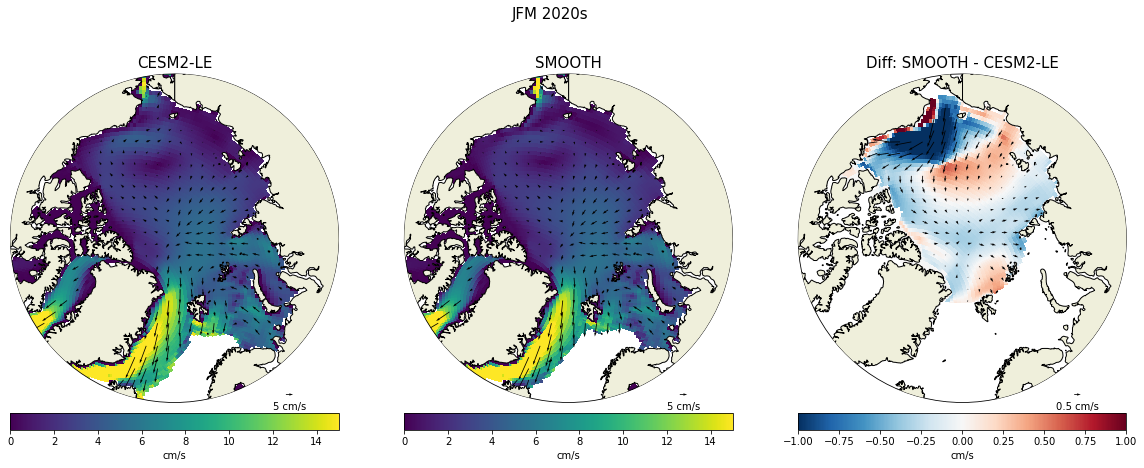

In [72]:
# set some plotting info
vmax_in = 15
vmin_in = 0
cmap_in = plt.cm.get_cmap('viridis')
vmax_diff = 1
vmin_diff = -1
cmap_diff = plt.cm.get_cmap('RdBu')
cmap_diff = cmap_diff.reversed()
intv = 5

# Loop through the seasons and decades
for ss in season_names[0:1]:
#for ss in season_names:
    for dec in decade_names[0:1]:
        # set figure output info
        title = ss+' '+dec+'s'
        fout = 'cesm2_le_and_rufmod_difference_decadal_ice_speed_'+ss+'_'+dec+'s'
        
        # select the data
        u_tmp_le=uvel_seas_dec_le_rot.sel(season=ss,decades=dec)
        v_tmp_le=vvel_seas_dec_le_rot.sel(season=ss,decades=dec)
        spd_tmp_le = spd_seas_dec_le.sel(season=ss,decades=dec)
#        spd_tmp_le = np.sqrt(u_tmp_le**2 + v_tmp_le**2)

        u_tmp_rufmod=uvel_seas_dec_rufmod_rot.sel(season=ss,decades=dec)
        v_tmp_rufmod=vvel_seas_dec_rufmod_rot.sel(season=ss,decades=dec)
        spd_tmp_rufmod = spd_seas_dec_rufmod.sel(season=ss,decades=dec)
#        spd_tmp_rufmod = np.sqrt(u_tmp_rufmod**2 + v_tmp_rufmod**2)

        u_diff = u_tmp_rufmod - u_tmp_le
        v_diff = v_tmp_rufmod - v_tmp_le
        spd_diff = spd_tmp_rufmod - spd_tmp_le 
        
        # mask difference only for central arctic
        u_diff = u_diff.where(mask_both ==1)
        v_diff = v_diff.where(mask_both ==1)
        spd_diff = spd_diff.where(mask_both ==1) 
        
        # create figure
        fig = plt.figure(figsize=(20,20),linewidth=10)
        
        # Make first plot
        ax = plt.subplot(1,3,1,projection = ccrs.NorthPolarStereo() )
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
        ## plot speed
        this = ax.pcolormesh(TLONG_plt.values,TLAT_plt.values,
                             spd_tmp_le,
                             transform=ccrs.PlateCarree(),
                             cmap = cmap_in, vmax=vmax_in, vmin=vmin_in)
        ## add vectors
        Q = ax.quiver(TLONG_sub[::intv,::intv].values,TLAT_sub[::intv,::intv].values,
                      u_tmp_le[::intv,::intv].values,v_tmp_le[::intv,::intv].values,
                      regrid_shape=30,
                      transform=ccrs.PlateCarree())
        plt.colorbar(this,orientation='horizontal',label=units,fraction=0.03,pad=0.01)
        qk = ax.quiverkey(Q,0.85,0.025,5,r'5 '+units,labelpos='S', coordinates='axes',color='black',zorder=2)
        plt.title('CESM2-LE',fontsize=15)

        # Make second plot
        ax = plt.subplot(1,3,2,projection = ccrs.NorthPolarStereo() )
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
        ## plot speed
        this = ax.pcolormesh(TLONG_plt.values,TLAT_plt.values,
                             spd_tmp_rufmod,
                             transform=ccrs.PlateCarree(),
                             cmap = cmap_in, vmax=vmax_in, vmin=vmin_in)
        ## add vectors
        Q = ax.quiver(TLONG_sub[::intv,::intv].values,TLAT_sub[::intv,::intv].values,
                      u_tmp_rufmod[::intv,::intv].values,v_tmp_rufmod[::intv,::intv].values,
                      regrid_shape=30,
                      transform=ccrs.PlateCarree())
        plt.colorbar(this,orientation='horizontal',label=units,fraction=0.03,pad=0.01)
        qk = ax.quiverkey(Q,0.85,0.025,5,r'5 '+units,labelpos='S', coordinates='axes',color='black',zorder=2)
        plt.title('SMOOTH',fontsize=15)

        # Make last (Diff) plot
        ax = plt.subplot(1,3,3,projection = ccrs.NorthPolarStereo() )
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
        ## plot speed
        this = ax.pcolormesh(TLONG_plt.values,TLAT_plt.values,
                             spd_diff,
                             transform=ccrs.PlateCarree(),
                             cmap = cmap_diff, vmax=vmax_diff, vmin=vmin_diff)
        ## add vectors
        Q = ax.quiver(TLONG_sub[::intv,::intv].values,TLAT_sub[::intv,::intv].values,
                      u_diff[::intv,::intv].values,v_diff[::intv,::intv].values,
                      regrid_shape=30,
                      transform=ccrs.PlateCarree())
        plt.colorbar(this,orientation='horizontal',label=units,fraction=0.03,pad=0.01)
        qk = ax.quiverkey(Q,0.85,0.025,0.5,r'0.5 '+units,labelpos='S', coordinates='axes',color='black',zorder=2)
        plt.title('Diff: SMOOTH - CESM2-LE',fontsize=15)

        # now add final titles
        fig.suptitle(title,fontsize=15, y=0.43) 
        #fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

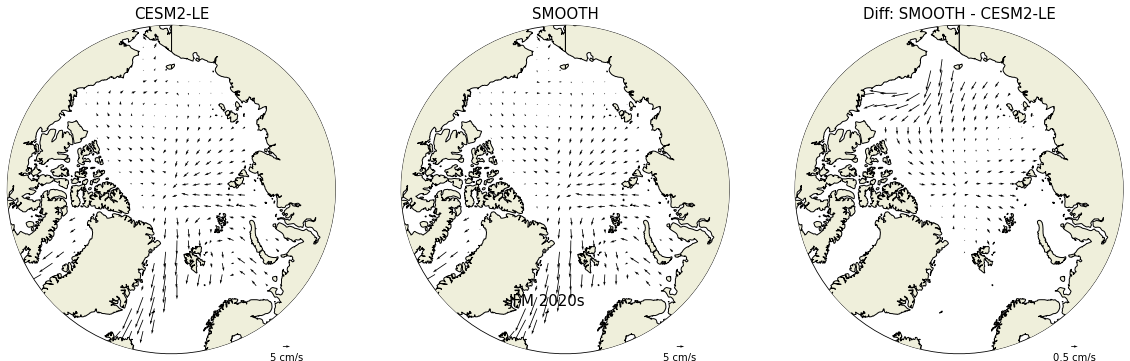

In [73]:
# set some plotting info
vmax_in = 15
vmin_in = 0
cmap_in = plt.cm.get_cmap('viridis')
vmax_diff = 1
vmin_diff = -1
cmap_diff = plt.cm.get_cmap('RdBu')
cmap_diff = cmap_diff.reversed()
intv = 5

# Loop through the seasons and decades
for ss in season_names[0:1]:
#for ss in season_names:
    for dec in decade_names[0:1]:
        # set figure output info
        title = ss+' '+dec+'s'
        fout = 'cesm2_le_and_rufmod_difference_decadal_ice_speed_'+ss+'_'+dec+'s'
        
        # select the data
        u_tmp_le=uvel_seas_dec_le_rot.sel(season=ss,decades=dec)
        v_tmp_le=vvel_seas_dec_le_rot.sel(season=ss,decades=dec)
        spd_tmp_le = spd_seas_dec_le.sel(season=ss,decades=dec)
#        spd_tmp_le = np.sqrt(u_tmp_le**2 + v_tmp_le**2)

        u_tmp_rufmod=uvel_seas_dec_rufmod_rot.sel(season=ss,decades=dec)
        v_tmp_rufmod=vvel_seas_dec_rufmod_rot.sel(season=ss,decades=dec)
        spd_tmp_rufmod = spd_seas_dec_rufmod.sel(season=ss,decades=dec)
#        spd_tmp_rufmod = np.sqrt(u_tmp_rufmod**2 + v_tmp_rufmod**2)

        u_diff = u_tmp_rufmod - u_tmp_le
        v_diff = v_tmp_rufmod - v_tmp_le
        spd_diff = spd_tmp_rufmod - spd_tmp_le 
        
        # mask difference only for central arctic
        u_diff = u_diff.where(mask_both ==1)
        v_diff = v_diff.where(mask_both ==1)
        spd_diff = spd_diff.where(mask_both ==1) 
        
        # create figure
        fig = plt.figure(figsize=(20,20),linewidth=10)
        
        # Make first plot
        ax = plt.subplot(1,3,1,projection = ccrs.NorthPolarStereo() )
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
        ## add vectors
        Q = ax.quiver(TLONG_sub[::intv,::intv].values,TLAT_sub[::intv,::intv].values,
                      u_tmp_le[::intv,::intv].values,v_tmp_le[::intv,::intv].values,
                      regrid_shape=30,
                      transform=ccrs.PlateCarree())
        qk = ax.quiverkey(Q,0.85,0.025,5,r'5 '+units,labelpos='S', coordinates='axes',color='black',zorder=2)
        plt.title('CESM2-LE',fontsize=15)

        # Make second plot
        ax = plt.subplot(1,3,2,projection = ccrs.NorthPolarStereo() )
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
        ## add vectors
        Q = ax.quiver(TLONG_sub[::intv,::intv].values,TLAT_sub[::intv,::intv].values,
                      u_tmp_rufmod[::intv,::intv].values,v_tmp_rufmod[::intv,::intv].values,
                      regrid_shape=30,
                      transform=ccrs.PlateCarree())
        qk = ax.quiverkey(Q,0.85,0.025,5,r'5 '+units,labelpos='S', coordinates='axes',color='black',zorder=2)
        plt.title('SMOOTH',fontsize=15)

        # Make last (Diff) plot
        ax = plt.subplot(1,3,3,projection = ccrs.NorthPolarStereo() )
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
        ## add vectors
        Q = ax.quiver(TLONG_sub[::intv,::intv].values,TLAT_sub[::intv,::intv].values,
                      u_diff[::intv,::intv].values,v_diff[::intv,::intv].values,
                      regrid_shape=30,
                      transform=ccrs.PlateCarree())
        qk = ax.quiverkey(Q,0.85,0.025,0.5,r'0.5 '+units,labelpos='S', coordinates='axes',color='black',zorder=2)
        plt.title('Diff: SMOOTH - CESM2-LE',fontsize=15)

        # now add final titles
        fig.suptitle(title,fontsize=15, y=0.43) 
        #fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)